In [1]:
# Name: example_density_analysis.ipynb
# Authors: Stephan Meighen-Berger
# Example simulation runs to check the number of flashes vs organism density

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from tqdm import tqdm
import pickle
from scipy.signal import find_peaks

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [5]:
# picture path
PICS = '../pics/'

In [6]:
# Module imports
from fourth_day import Fourth_Day, config

In [7]:
# Density function
# Converts a given density organisms/m^3 to something usable by Fourth Day
def dens2fd(density, xlength, ylength, current_velocity, time_step):
    # Starting density
    volume = xlength * ylength
    start_dens = volume * density
    # Injection density
    injection_volume_per_time_step = ylength * current_velocity
    org_per_time_step = injection_volume_per_time_step * density
    return start_dens, org_per_time_step

In [8]:
# Some example settings
config["scenario"]["class"] = "Stored"
config["scenario"]["premature break"] = False
config['scenario']['duration'] = 6000
config['scenario']['organism movement'] = False
config['scenario']['exclusion'] = True
config['scenario']['injection']['y range'] = [0., 10.]
config['scenario']['light prop'] = {
            "switch": True,
            "x_pos": 5.,
            "y_pos": 10.,
        }
config['scenario']['detector'] = {
    "switch": True,
    "type": "Custom",
    "response": True,
    "acceptance": "Flat",
    "mean detection prob": 0.5
}
# Organisms 
config['organisms']['emission fraction'] = 0.1
config['organisms']['alpha'] = 2.
config["organisms"]["filter"] = 'depth'
config["organisms"]["depth filter"] = 100000  # Note the absurd depth. This is used to exclusively simulate custom organisms
# Geometry
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 26.,
    'y_length': 10.,
    'offset': None,
}
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 26.,
    'y_length': 10.,
    "offset": np.array([0., 0.]),
}
config['geometry']["exclusion"] = {
    "function": "sphere",
    "radius": 0.15,
    "x_pos": 2.,
    "y_pos": 5.,
}
# Water
config['water']['model']['name'] = 'custom' # 'potential cylinder'
config['water']['model']['directory'] = "../data/current/Long_run_corr/"
config['water']['model']['time step'] = 0.1
config['advanced']['starting step'] = 0
# Detector
config["geometry"]["detector properties"]["Custom"] = {
    "x_pos": 2.,
    "y_pos": 5.,
    "det num": 1,
    "x_offsets": np.array(
        [0.]
    ),
    "y_offsets": np.array(
        [0.]
    ),
    "angle offset": 0.,  # In which direction the detector points
    "opening angle": 360.,  # 25., # from dark box rotation test result: +-25 degrees
    "wavelength acceptance": [ #position number,center wavelength,quantum efficiency
        [325., 600.,1.],                               
    ],
}

In [9]:
# Launching multiple simulations to use in the analysis
seeds = range(20)
warm_up = 3000
densities = np.logspace(-3, -1, 10)
flash_vs_dens = []
flash_vs_dens_std = []
for density in densities:
    starting_org, inject_org = dens2fd(density, 26., 10., 0.1, 0.1)
    peak_arr = []
    for seed in tqdm(seeds):
        # General
        config["general"]["random state seed"] = seed
        config['scenario']['population size'] = 10
        config['scenario']['injection']['rate'] = inject_org
        config["scenario"]["statistics storage"]["name"] = "dens_run_dens_%.1e_seed_%d" %(density, seed)
        # Creating a fourth_day object
        fd = Fourth_Day()
        # Launching solver
        fd.sim()
        totals = fd.measured["Detector 0"].values
        # Skipping the warm-up phase
        totals = totals[warm_up:]
        peaks, _ = find_peaks(totals, height=0)
        peak_arr.append(len(peaks))
    peak_arr = np.array(peak_arr)
    flash_vs_dens.append(np.mean(peak_arr))
    flash_vs_dens_std.append(np.std(peak_arr))
flash_vs_dens = np.array(flash_vs_dens)
flash_vs_dens_std = np.array(flash_vs_dens_std)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [23:12<00:00, 69.64s/it]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


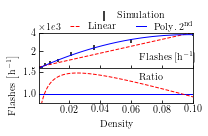

In [10]:
from scipy import stats
plot_data = np.copy(flash_vs_dens)
scaling = 12.
plot_data = plot_data * scaling  # Average per hour
z1 = np.polyfit(densities, plot_data, 1, w=1./flash_vs_dens_std)
z = np.polyfit(densities, plot_data, 2, w=1./flash_vs_dens_std)
p1 = np.poly1d(z1)
p = np.poly1d(z)
# Plotting standards
std_size = 3.
fontsize = 10.
lw=1.
h_length=1.
# Plot figure with subplots of different sizes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
# ---------------------------------------------------------------------------------------------------
# Plot parameters
ylow = 1e-3
yhigh = 0.1
# xlow = 0
# xhigh = 10
# ---------------------------------------------------------------------------------------------------
# The average emissions
ax1.errorbar(
    densities,
    plot_data / 1e3,
    yerr= flash_vs_dens_std * scaling / 1e3,
    linestyle="None", color='k', label=r'$\mathrm{Simulation}$')
ax1.plot(np.logspace(-4, 0, 100), p1(np.logspace(-4, 0, 100)) / 1e3, 'r', lw=lw, ls='--', label=r'$\mathrm{Linear}$')
ax1.plot(np.logspace(-4, 0, 100), p(np.logspace(-4, 0, 100)) / 1e3, 'b', ls='-', lw=lw, label=r'$\mathrm{Poly.\;2^{nd}}$')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
# ax1.set_ylabel(r'$\mathrm{Flashes}\;[\mathrm{h}^{-1}]$', fontsize=fontsize)
ax1.text(0.065, 1., r'$\mathrm{Flashes}\;[\mathrm{h}^{-1}]$', fontsize=fontsize)
ax1.text(0.001, 4.5, r'$\times 1e3$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.set_xlim(ylow, yhigh)
ax1.set_ylim(1e-1, 4e0)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h[:2],l[:2], loc=9, bbox_to_anchor=(0.6, +1.6),
                  ncol=5, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
lgd2 = ax1.legend([h[2]],[l[2]], loc=9, bbox_to_anchor=(0.6, +1.9),
                  ncol=5, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.add_artist(lgd1)
# ---------------------------------------------------------------------------------------------------
# The fraction
ax2.plot(np.logspace(-4, 0, 100), p(np.logspace(-4, 0, 100)) / p1(np.logspace(-4, 0, 100)), 'r', lw=lw, ls='--')
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_xlabel(r'$\mathrm{Density}$', fontsize=fontsize)
ax2.set_ylabel(r'$\mathrm{Flashes}\;\left[\mathrm{h}^{-1}\right]$', fontsize=fontsize)
ax2.text(0.065, 1.3, r'$\mathrm{Ratio}$', fontsize=fontsize)
ax2.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax2.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax2.set_xlim(ylow, yhigh)
ax2.set_ylim(0.8, 1.6)
ax2.hlines(1., 0., 1., color='b', lw=lw)
# ---------------------------------------------------------------------------------------------------
# General
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
fig.savefig(PICS + "MC_Peak_Count_Average.pdf",
            bbox_inches='tight')

In [11]:
# How to store
plot_data = {
    "densities": densities,
    "sim_Y": plot_data / 1e3,
    "sim_Y_err": flash_vs_dens_std * scaling / 1e3,
}
pickle.dump(plot_data, open( "C:\\Users\\steph\\Documents\\PhD\\unified_thesis_plots\\data\\bio_dens_flash.p", "wb"))